In [ ]:
from langgraph.graph import StateGraph, START, END 
import os 
from langchain_google_genai import ChatGoogleGenerativeAI 
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel,Field  
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage

In [3]:
load_dotenv()

True

In [4]:
os.environ['GOOGLE_API_KEY'] = os.getenv('gemini_api_key') 
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [5]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash") 
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash") 
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [9]:
class TweetState(TypedDict):
    topic: str
    tweet: str 
    evaluation: Literal["approved","need_improvement"]
    feedback:str 
    iteration: int 
    max_iteration: int 


In [12]:
from pydantic import BaseModel, Field 
class TweetEvaluation(BaseModel): 
    evaluation: Literal["approved", "need_improvement"] = Field(..., description="Final Evaluation of the tweet")
    feedback:str = Field(..., description="Write feedback for the tweet ")

In [13]:
structured_evalator_llm = model.with_structured_output(TweetEvaluation)

In [ ]:
def  generate_tweet(state:TweetState) : 
    message = [
        SystemMessage(content = "You are expert in writing tweets in X platform"),
        HumanMessage(content = f""" , write a detailed tweet for the given topic {state["topic"]} 
                    The topic should be short , original, and funny 
                    Rules: 
                    - Do not use question answer format 
                    -Max 280 characters
                    - use observational, humor,irony,sarcasm or cultural references. 
                    - Think in meme, punchlines or relatable takes
                    -Use simple day to day english
                                                """) ]
    response = generator_llm.invoke(message).content 

    return {"tweet" : response} 

In [17]:
def  evaluate_tweet(state:TweetState) : 
    prompt =f""" You are expert in evaluating tweets in X platform, Evaluate the tweet for the given topic {state["tweet"]} 
The evaluation  should original, freshness ...  
Approve the tweet or 
Reject the tweet if it does not following the below rules \n 
- Do not use question answer format 
-Max 280 characters
- use observational, humor,irony,sarcasm or cultural references. 
- Think in meme, punchlines or relatable takes
-Use simple day to day english
""" 
    response = structured_evalator_llm.invoke(prompt)

    return {"evaluation" : response.evaluation,
            "feedback": response.feedback}

In [18]:
from langchain_core.messages import SystemMessage, HumanMessage
def optmize_tweet(state: TweetState): 
   messages = [
      SystemMessage(content= "You punch up tweet for virality and humor based on given feedback "),
      HumanMessage(content= f""" 
Improve the tweet based on this feedback:
                   Improve the tweet based on this feedback:
                   {state['feedback']}
Topic: {state['topic']}
Orginal Tweet : {state['tweet']}
Rewrite it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.

""")
   ]
   response = optimizer_llm(messages).content
   iteration = state['iteration'] + 1 

   return {'tweet': response, "iteration" : iteration}


In [20]:
def route_evalution(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvement'

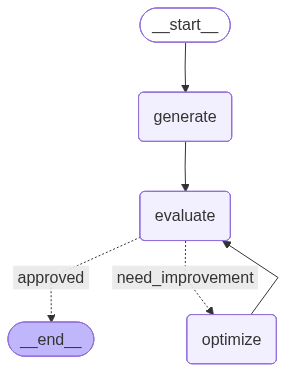

In [22]:
graph = StateGraph(TweetState) 

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optmize_tweet) 

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate',route_evalution, {'approved':END,'need_improvement':'optimize'})
graph.add_edge('optimize','evaluate') 

graph.compile()



In [23]:
workflow = graph.compile() 

In [26]:
initial_state = {
    "topic": "AI its impacts on Human",
    "iteration" : 1,
    "max_iteration":5
}

In [27]:
workflow.invoke(initial_state)

{'topic': 'AI its impacts on Human',
 'tweet': "AI can write symphonies, diagnose diseases, and probably even fold fitted sheets perfectly. My only remaining purpose is to find my phone charger. Guess I'm still essential. #AIImpact #HumanSkills",
 'evaluation': 'approved',
 'feedback': "The tweet brilliantly uses humor and relatable everyday struggles to comment on AI's advancements, making a fresh and engaging point about human relevance. The contrast between AI's complex tasks and the simple act of finding a phone charger is a comedic gold, concluding with a witty, self-aware punchline. It perfectly aligns with the guidelines for observational humor and relatable takes.",
 'iteration': 1,
 'max_iteration': 5}